# Algorithm Hierarchical Clustering M

describe

In [6]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n
        self.nodes = set([n])
        self.active = True
        self.join_n = a = -1 
        self.dist = -1

    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes)
        c.active = False
        c.join_n = self.n
        c.dist = dist
        
    def get_n(self):
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
    
    def score(sefl, x):
        ''' '''
    
    def _get_min(self, M, C):
        r = []
        for i in range(len(C)):  
            for j in range(i,len(C)):
                if( M[i][j] <= 0):
                    continue
                a = C[i].get_n()
                b = C[j].get_n()  
                if(a == b):
                    continue
                r.append( M[i][j])    
        return min(r)    
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0]) * self.alpha 
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
            joins = set([])
            for i in range(size):  
                for j in range(i,size):  
                    if(M[i][j] <= 0 or M_[i][j] > 0): # old
                        continue
                    if i == j:
                        continue 
                    if j in joins and C[i].dist > M_[i][j]:
                        #print('joins | i(%d) j(%d) - dist(%.3f) M(%.3f) ' % (i,j, C[i].dist, M_[i][j]))
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue  
                    #if  (C[b].active == False or C[a].active == False):
                    #    continue
                    
                    joins.add(j)     
            
                    C[a].merge(C[b], M_[i][j])
                    for s in C[b].nodes:
                        C[s].join_n = a
                    #sb = C[b][0]
                    #C[a][0] = C[a][0].union(sb)  
                    #for s in sb:
                    #    C[s][1] = C[s][1] - 1
                    #    C[s][2] = a 
                    #C[a][1] = 1 
                    #M_[b,:] = 0 
                    #M_[:,b] = 0

                    #print(M_[b])
                    join = True
            #print('join', join)        
            if join == False:
                #break
                delta = delta * self.betta
                continue
            ''' update matrix '''
            #delta = d
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                print('len(M[M > 0]) == 0')
                #print(M_)
                break
              
            #print(C)
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
            print('unique len: %d' % len(np.unique(y_)))
            if len(np.unique(y_)) == 1:
                print('len(np.unique(y_)) == 1')
                break
            neg,pos = [],[]    
            for i in range(size): 
                for j in range(i,size):
                    if(M[i][j] <= 0):
                        neg.append(delta + np.abs(M[i][j]))
                    else:
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) / len(pos), sum(neg) / len(neg),np.std(pos), np.std(neg))) 
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                #break  
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [46]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([
    [1,1],
    [1,2],
    [2,2],
    [2,1],
    
    #[4,4],
    
    [5,5], 
    [6,6],
    [6,7],
    
    [3.5,7],
    
    # 
    [3.6,7.1],
    [3.7,6.9],
    [3.8,6.9] 
]) 

def draw(x, y):
    k = 2
    U,s,vh = np.linalg.svd(x) 
    k = min(k, len(s))

    x1 = np.dot(U[:,0:k] * s[0:k], vh[0:k]) 

    plt.rcParams["figure.figsize"] = (12,12)
    plt.scatter(x1[:,0], x1[:,1], c=y)

   

Hierarchical clustering
delta: 0.110, d: 0.110
unique len: 10
Sum pos: 3.783, sum neg: 0.212, Std pos: 2.352, Std neg: 0.028
delta: 0.110, d: 0.035
unique len: 9
Sum pos: 3.744, sum neg: 0.311, Std pos: 2.317, Std neg: 0.044
delta: 0.110, d: 0.004
unique len: 8
Sum pos: 3.936, sum neg: 0.364, Std pos: 2.144, Std neg: 0.112
delta: 0.737, d: 0.737
unique len: 4
Sum pos: 3.570, sum neg: 1.518, Std pos: 1.941, Std neg: 0.400
delta: 0.737, d: 0.382
unique len: 3
Sum pos: 3.069, sum neg: 2.120, Std pos: 1.797, Std neg: 0.524
delta: 0.737, d: 0.438
unique len: 2
Sum pos: 3.250, sum neg: 2.262, Std pos: 1.125, Std neg: 1.000
delta: 0.737, d: 0.109
delta: 1.474, d: 0.109
delta: 2.948, d: 0.109
unique len: 1
len(np.unique(y_)) == 1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


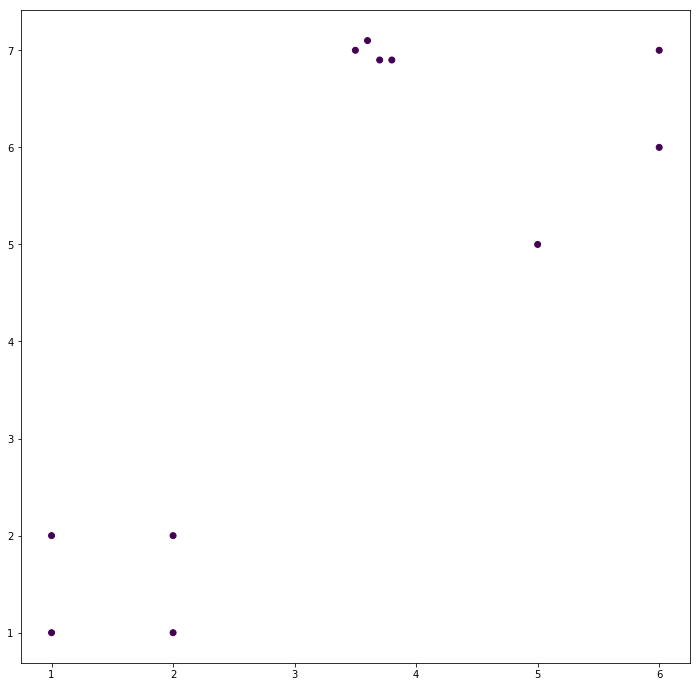

In [47]:
#x = np.array([
#    [1,1],[2.2,2.2],[3.5,3.5],[4.9,4.9]
#])
hc = HierarchicalClustering(alpha = 1.1, debug=True)
hc.print_name()
Y_ = hc.fit(x)
print(Y_)
draw(x, Y_)

[0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 2.]


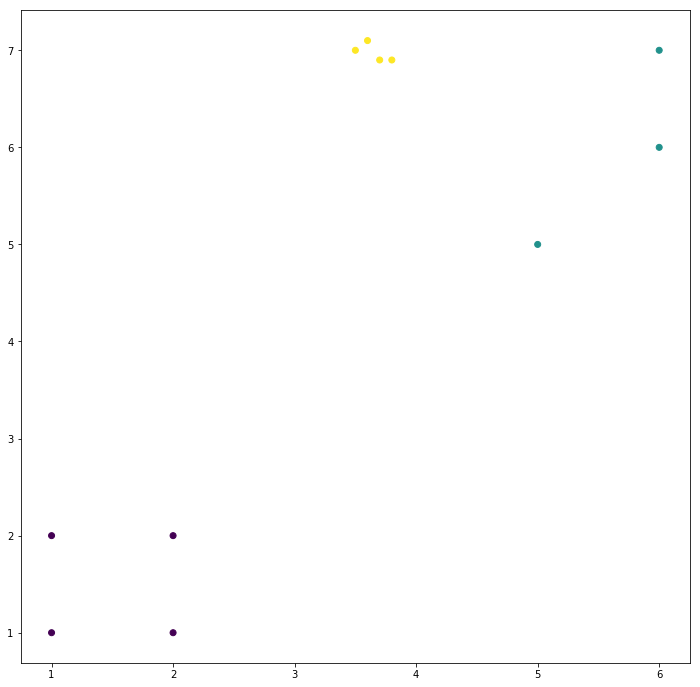

In [48]:
n = -3
print(hc._c_all[n])
draw(x, hc._c_all[n])

unique len: 145
unique len: 83
unique len: 24
unique len: 11
unique len: 4
unique len: 3
unique len: 2
unique len: 1
len(np.unique(y_)) == 1


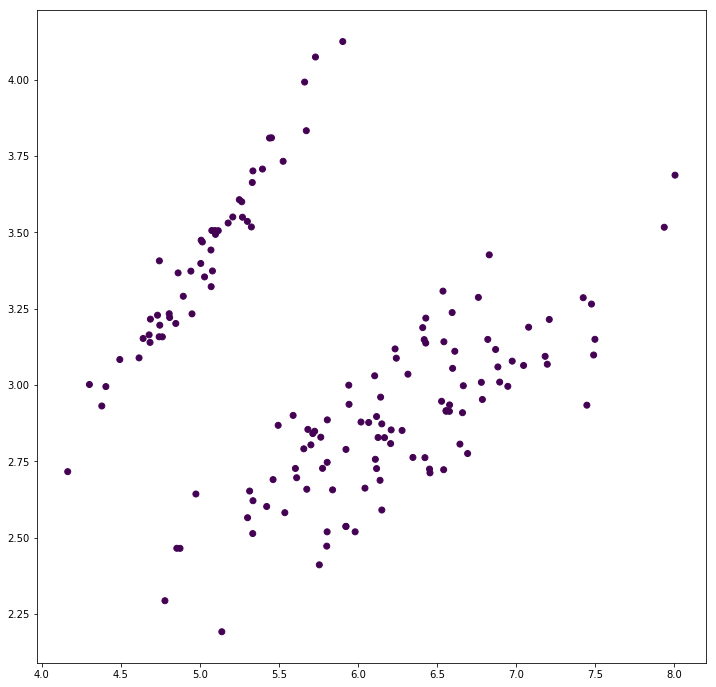

In [49]:
data = load_iris()
ix = data.data
iy = data.target
cl = HierarchicalClustering(alpha=1.3, debug=0, max_iteration=100)
iiy = cl.fit(ix)
draw(ix,iiy)

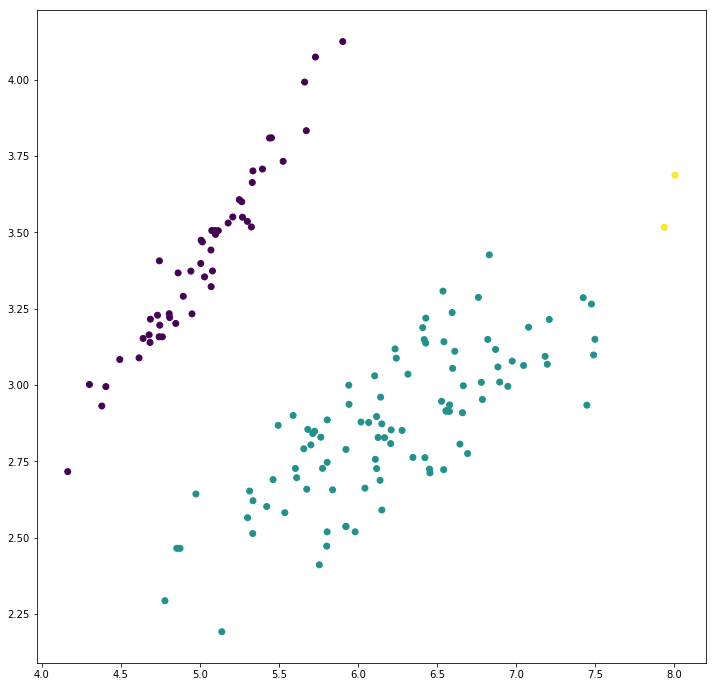

In [50]:
draw(ix,cl._c_all[-3])
#draw(ix, iy)

delta: 0.001, d: 0.001
unique len: 999
Sum pos: 1.238, sum neg: 0.002, Std pos: 0.685, Std neg: 0.000
delta: 0.001, d: 0.000
unique len: 995
Sum pos: 1.237, sum neg: 0.003, Std pos: 0.685, Std neg: 0.000
delta: 0.001, d: 0.000
unique len: 994
Sum pos: 1.236, sum neg: 0.004, Std pos: 0.685, Std neg: 0.000
delta: 0.001, d: 0.000
unique len: 986
Sum pos: 1.236, sum neg: 0.005, Std pos: 0.685, Std neg: 0.000
delta: 0.001, d: 0.000
unique len: 977
Sum pos: 1.235, sum neg: 0.006, Std pos: 0.685, Std neg: 0.000
delta: 0.001, d: 0.000
unique len: 963
Sum pos: 1.234, sum neg: 0.006, Std pos: 0.685, Std neg: 0.001
delta: 0.001, d: 0.000
unique len: 948
Sum pos: 1.233, sum neg: 0.007, Std pos: 0.685, Std neg: 0.001
delta: 0.001, d: 0.000
unique len: 930
Sum pos: 1.232, sum neg: 0.008, Std pos: 0.685, Std neg: 0.001
delta: 0.001, d: 0.000
unique len: 908
Sum pos: 1.231, sum neg: 0.009, Std pos: 0.685, Std neg: 0.002
delta: 0.001, d: 0.000
unique len: 888
Sum pos: 1.230, sum neg: 0.010, Std pos: 0.

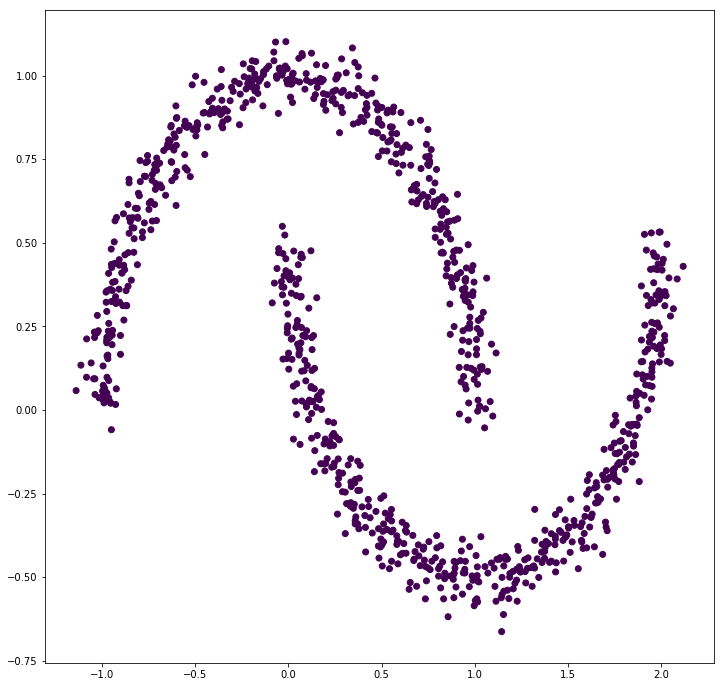

In [51]:
# noisy_moons
from sklearn import cluster, datasets, mixture
mx,my =  datasets.make_moons(n_samples=300, noise=.05)

cl2 = HierarchicalClustering(alpha=1., debug=1)
mmy = cl2.fit(mx)
draw(mx,mmy)

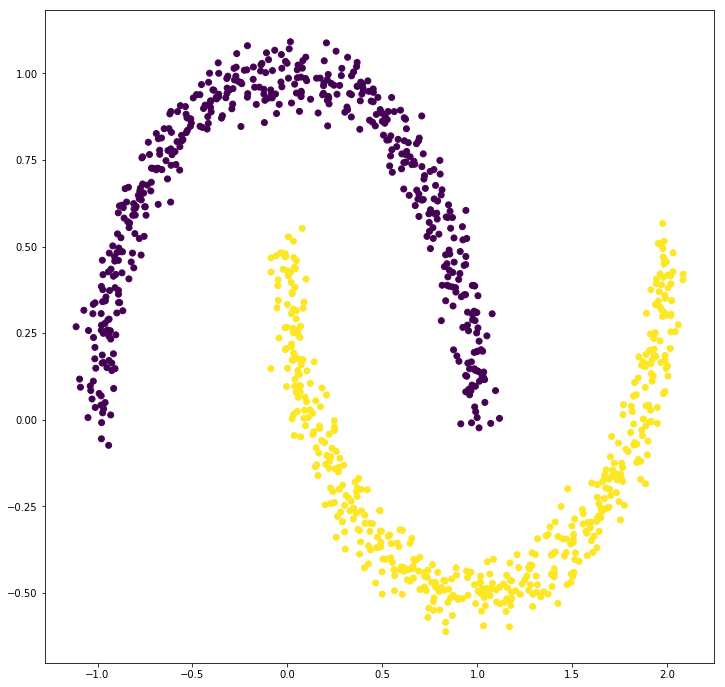

In [21]:
n = -2
#print(cl2._c_all[n])
draw(mx,cl2._c_all[n])

delta: 0.500, d: 0.015
unique len: 49
Sum pos: 553600264.320, sum neg: 412811.842, Std pos: 8.189, Std neg: 0.124
delta: 0.500, d: 0.000
unique len: 8
Sum pos: 529286084.167, sum neg: 1942047.189, Std pos: 8.066, Std neg: 0.241
delta: 0.500, d: 0.000
unique len: 4
Sum pos: 506014246.888, sum neg: 4882916.411, Std pos: 7.870, Std neg: 0.361
delta: 0.500, d: 0.000
unique len: 2
Sum pos: 484044162.533, sum neg: 9271179.556, Std pos: 7.602, Std neg: 0.483
delta: 0.500, d: 0.000
delta: 1.000, d: 0.000
delta: 2.000, d: 0.000
delta: 4.000, d: 0.000
delta: 8.000, d: 0.000
unique len: 1
len(np.unique(y_)) == 1


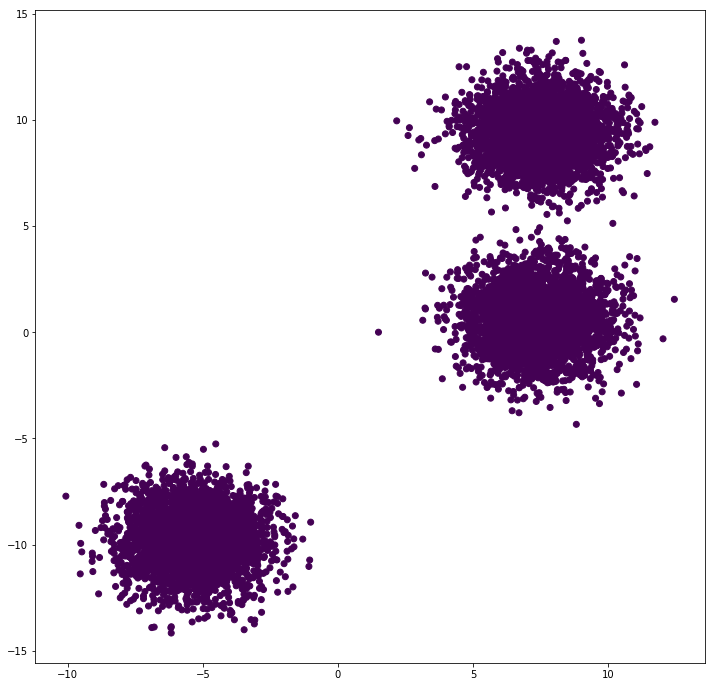

In [206]:
bx,_ =  datasets.make_blobs(n_samples=10000, random_state=8, cluster_std=1.3) 

cl3 = HierarchicalClustering(alpha=100., debug=1,max_iteration=100,delta=.5)
by = cl3.fit(bx)
draw(bx,by)

[0. 1. 2. 3. 4. 5. 6. 7.]


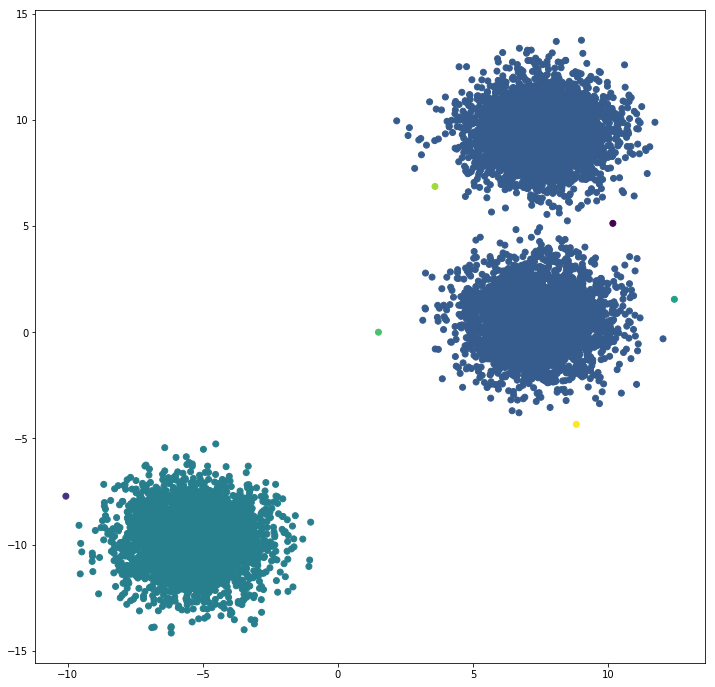

In [208]:
n = -4
#print(cl3._c_all[n])
print(np.unique(cl3._c_all[n]))
draw(bx,cl3._c_all[n])

### fetch_20newsgroups

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [4]:
y_train, y_test = data_train.target, data_test.target

In [7]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.38 s, sys: 16 ms, total: 6.4 s
Wall time: 6.41 s


In [13]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=100): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [14]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 3min 6s, sys: 1min 36s, total: 4min 43s
Wall time: 2min 55s


In [15]:
print(X_train_.shape)

(11314, 100)
